# Teaching Gemma how to think – Structured reasoning using TUNIX

This notebook presents our submission for the Kaggle competition “Google Tunix Hack – Train a model to show its work.” The goal of the challenge is to fine-tune a Gemma model (here: Gemma 3 1B) so that it produces an explicit reasoning trace before giving the final answer.

As required in the competition guidelines, we enforce a strict output format:
- The reasoning trace must be wrapped in \<reasoning> ... \</reasoning> tags
- The final answer must be wrapped in \<answer> ... \</answer> tags

We build on Windmaple’s starter notebook ([grpo-demo-gemma3-1b](https://www.kaggle.com/code/windmaple/grpo-demo-gemma3-1b)) and extend it with a two-stage training pipeline designed for the limited compute budget available in Kaggle notebook sessions:
1. Supervised Fine-Tuning (SFT): Because SFT is faster and more efficient than GRPO we start by Fine-Tuning the model using SFT to teach the model the shape of a valid response. Our idea behind that is, to give the model a kind of kickstart into the training to save resources and speed up the training.
2. Group Relative Policy Optimization Fine-Tuning (GRPO): After bringing the model on the right track by SFT, we continue with GRPO. GRPO is beneficial in a way, that the model has more freedom to explore different solutions and lets us incorporate datasets, that do not contain reasoning traces at all.

Speaking of data, we used the following datasets for tranining the Gemma3 1B model:
- [openai/gsm8k](https://huggingface.co/datasets/openai/gsm8k): A dataset containing grade school math questions, including answers with step by step solutions.
- [nguyen-brat/worldtree](https://huggingface.co/datasets/nguyen-brat/worldtree): A dataset of multiple-choice elementary science questions with supporting reasoning-like explanation facts.
- [allenai/ai2_arc](https://huggingface.co/datasets/allenai/ai2_arc): A dataset containing grade-school level, multiple choice science questions with answers, but not reasoning traces.


For the SFT stage, we used the gsm8k and worldtree datasets because both provided reasoning-like traces. We continued using both datasets for GRPO but also added with ai2_arc another dataset, that doesn't include traces. 

## Installing dependencies

In [2]:
!pip install -q kagglehub
!pip install -q kaggle

!pip install -q ipywidgets

!pip install -q grain
!pip install "google-tunix[prod]==0.1.3"

!pip uninstall -q -y flax
!pip install flax==0.12.0

!pip install -q datasets wandb==0.22.0


[notice] A new release of pip is available: 25.0.1 -> 25.3
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 25.0.1 -> 25.3
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 25.0.1 -> 25.3
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 25.0.1 -> 25.3
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 25.0.1 -> 25.3
[notice] To update, run: pip install --upgrade pip
  Using cached flax-0.12.0-py3-none-any.whl.metadata (11 kB)
Using cached flax-0.12.0-py3-none-any.whl (466 kB)

[notice] A new release of pip is available: 25.0.1 -> 25.3
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 25.0.1 -> 25.3
[notice] To update, run: pip install --upgrade pip


## Secrets and Logging
We start by loading the Kaggle API credentials from the secrets (if you want to run this notebook, make sure that you entered and activated them in the secrets tab). We also disable Weights & Biases to avoid logging-related issues.

In [3]:
import os
from kaggle_secrets import UserSecretsClient

user_secrets_client = UserSecretsClient()

kaggle_username = user_secrets_client.get_secret("KAGGLE_USERNAME")
kaggle_key = user_secrets_client.get_secret("KAGGLE_KEY_LEGACY")

os.environ["KAGGLE_USERNAME"] = kaggle_username
os.environ["KAGGLE_KEY"] = kaggle_key
os.environ["HF_HUB_DISABLE_XET"] = "1"

os.environ["WANDB_MODE"] = "disabled"
os.environ["WANDB_SILENT"] = "true"
os.environ["WANDB_CONSOLE"] = "off"

import wandb
wandb.init(mode="disabled")

/usr/local/lib/python3.12/site-packages/pydantic/_internal/_generate_schema.py:2262: UnsupportedFieldAttributeWarning: The 'repr' attribute with value False was provided to the `Field()` function, which has no effect in the context it was used. 'repr' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `type` statement was used, or if the `Field()` function was attached to a single member of a union type.
  warnings.warn(
/usr/local/lib/python3.12/site-packages/pydantic/_internal/_generate_schema.py:2262: UnsupportedFieldAttributeWarning: The 'frozen' attribute with value True was provided to the `Field()` function, which has no effect in the context it was used. 'frozen' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `type` 

## Imports

In [4]:
import csv
import functools
import gc
import os
import re
import wandb
import humanize
import numpy as np
import pandas as pd
import shutil
import kagglehub
import matplotlib.pyplot as plt
import pandas as pd

from collections import defaultdict
from dataclasses import dataclass
from datasets import load_dataset, interleave_datasets
from pathlib import Path
from pprint import pprint
from tensorboard.backend.event_processing.event_accumulator import EventAccumulator
from tqdm.auto import tqdm

from flax import nnx
import grain
import jax
import jax.numpy as jnp
import optax
from orbax import checkpoint as ocp
import qwix
from tunix.generate import sampler as sampler_lib
from tunix.generate import tokenizer_adapter as tokenizer_lib
from tunix.models.gemma3 import params
from tunix.models.gemma3 import model
from tunix.rl import rl_cluster as rl_cluster_lib
from tunix.rl.grpo.grpo_learner import GRPOConfig, GRPOLearner
from tunix.rl.rollout import base_rollout
from tunix.sft import metrics_logger
from tunix.sft import utils as sft_utils
from tunix.sft import peft_trainer, metrics_logger

/usr/local/lib/python3.12/site-packages/jax/_src/cloud_tpu_init.py:86: UserWarning: Transparent hugepages are not enabled. TPU runtime startup and shutdown time should be significantly improved on TPU v5e and newer. If not already set, you may need to enable transparent hugepages in your VM image (sudo sh -c "echo always > /sys/kernel/mm/transparent_hugepage/enabled")
  warnings.warn(


## Hyperparameter configuration

In this section, we define the hyperparameters used throughout training and evaluation. We separate the configuration into SFT and GRPO settings. All hyperparameters were selected empirically through experimentation, trying to balance training stability, runtime, and final performance.

In [5]:
# Data
TRAIN_DATA_DIR = "./data/train"
TEST_DATA_DIR = "./data/test"
TRAIN_FRACTION_SFT = 0.9
TRAIN_FRACTION_GRPO = 0.95

# LoRA
RANK = 64
ALPHA = 64.0

# Sharding
MESH = [(1, 4), ("fsdp", "tp")]

# Training hyperparameters
TRAIN_MICRO_BATCH_SIZE = 4

# SFT hyperparameters
NUM_ITERATIONS_SFT = 1
NUM_EPOCHS_SFT = 2
NUM_BATCHES_SFT = 850  # 850 => (765 train, 85 val)
NUM_TEST_BATCHES_SFT = 100
MAX_STEPS_SFT = int(NUM_BATCHES_SFT * NUM_ITERATIONS_SFT * NUM_EPOCHS_SFT * TRAIN_FRACTION_SFT )
EVAL_EVERY_N_STEPS_SFT = int((NUM_BATCHES_SFT * TRAIN_FRACTION_SFT) / 10)
print(f"Evaluate every {EVAL_EVERY_N_STEPS_SFT} steps during SFT")

LEARNING_RATE_SFT = 5e-6
WEIGHT_DECAY_SFT = 0.05
MAX_GRAD_NORM_SFT = 0.3

# GRPO hyperparameters
NUM_ITERATIONS_GRPO = 1
NUM_EPOCHS_GRPO = 1
NUM_BATCHES_GRPO = 1600 # 1600 => (1520 train, 80 val)
NUM_TEST_BATCHES_GRPO = 100
MAX_STEPS_GRPO = int(NUM_BATCHES_GRPO * NUM_ITERATIONS_GRPO * NUM_EPOCHS_GRPO * TRAIN_FRACTION_GRPO )
EVAL_EVERY_N_STEPS_GRPO = int((NUM_BATCHES_GRPO * TRAIN_FRACTION_GRPO) / 10) # 200
print(f"Evaluate every {EVAL_EVERY_N_STEPS_GRPO} steps during GRPO")

MAX_GRAD_NORM_GRPO = 0.1
LEARNING_RATE_GRPO = 2e-6
WEIGHT_DECAY_GRPO = 0.05

MAX_PROMPT_LENGTH = 256
TOTAL_GENERATION_STEPS = 512
TEMPERATURE = 0.8
TOP_P = 0.95
TOP_K = 50
NUM_GENERATIONS = 4
BETA = 0.12
EPSILON = 0.15

B1 = 0.9
B2 = 0.99
WARMUP_STEPS_GRPO = int(0.1 * MAX_STEPS_GRPO)

# Metric paths
SFT_METRICS_DIR = "/kaggle/working/sft_logs"
GRPO_METRICS_DIR = "/kaggle/working/grpo_logs"

# Checkpoint saving
INTERMEDIATE_CKPT_DIR = "/kaggle/working/intermediate_ckpt/"
GRPO_CKPT_DIR = "/kaggle/working/grpo_ckpts/"
METRICS_DIR = "/kaggle/working/tmp/tensorboard/grpo"
SFT_CKPT_DIR = "/kaggle/working/sft_ckpts"
SAVE_INTERVAL_STEPS = 500
MAX_TO_KEEP = 4

GENERATION_CONFIGS = {
    "greedy": {"temperature": 1e-4, "top_k": 1, "top_p": 1.0},
    "standard": {"temperature": 0.7, "top_k": 50, "top_p": 0.95},
    "liberal": {"temperature": 0.85, "top_k": 2000, "top_p": 1.0},
}

Evaluate every 76 steps during SFT
Evaluate every 152 steps during GRPO


## Model loading

Next, we load the Gemma 3 1B checkpoint and store it once in an intermediate checkpoint directory (adapted from Windmaple’s starter notebook). This gives us a clean starting point.

In [6]:
!rm -rf {INTERMEDIATE_CKPT_DIR}/*
!rm -rf {GRPO_CKPT_DIR}/*
!rm -rf {SFT_CKPT_DIR}/*

MODEL_CP_PATH = params.GEMMA3_1B_IT
config = model.ModelConfig.gemma3_1b()
gemma = params.create_model_from_checkpoint(MODEL_CP_PATH, config)
tokenizer = params.create_tokenizer()

checkpointer = ocp.StandardCheckpointer()
_, state = nnx.split(gemma)
checkpointer.save(os.path.join(INTERMEDIATE_CKPT_DIR, "state"), state)
checkpointer.wait_until_finished()

del params
del gemma
del state
_ = gc.collect()

E0000 00:00:1768030861.808975   12653 common_lib.cc:648] Could not set metric server port: INVALID_ARGUMENT: Could not find SliceBuilder port 8471 in any of the 0 ports provided in `tpu_process_addresses`="local"
=== Source Location Trace: === 
learning/45eac/tfrc/runtime/common_lib.cc:238
E0110 07:41:15.737548   13752 google_auth_provider.cc:188] Could not find the credentials file in the standard gcloud location [/root/.config/gcloud/application_default_credentials.json]. You may specify a credentials file using $GOOGLE_APPLICATION_CREDENTIALS, or to use Google application default credentials, run: gcloud auth application-default login


For GRPO, we work with two models: a frozen reference model that serves as a baseline, and a trainable policy model. The policy model is obtained by applying LoRA adapters, so only a small set of parameters is updated during training. That way, LoRA significantly reduces the number of trainable parameters while still allowing the model to adapt effectively. To load both models, we define the following two functions:

In [7]:
from tunix.models.gemma3 import params

def get_gemma_ref_model(ckpt_path):
    mesh = jax.make_mesh(*MESH)
    model_config = model.ModelConfig.gemma3_1b()
    abs_gemma: nnx.Module = nnx.eval_shape(
        lambda: params.create_model_from_checkpoint(MODEL_CP_PATH, config)
    )
    
    abs_state = nnx.state(abs_gemma)
    abs_state = jax.tree.map(
        lambda a, s: jax.ShapeDtypeStruct(a.shape, jnp.bfloat16, sharding=s),
        abs_state,
        nnx.get_named_sharding(abs_state, mesh),
    )
    checkpointer = ocp.StandardCheckpointer()
    restored_params = checkpointer.restore(ckpt_path, target=abs_state)
    
    graph_def, _ = nnx.split(abs_gemma)
    gemma = nnx.merge(graph_def, restored_params)
    return gemma, mesh, model_config


def get_lora_model(base_model, mesh):
    lora_provider = qwix.LoraProvider(
        module_path=".*q_einsum|.*kv_einsum|.*gate_proj|.*down_proj|.*up_proj|.*attn_vec_einsum",
        rank=RANK,
        alpha=ALPHA,
    )
    
    model_input = base_model.get_model_input()
    lora_model = qwix.apply_lora_to_model(base_model, lora_provider, **model_input)
    
    with mesh:
        state = nnx.state(lora_model)
        pspecs = nnx.get_partition_spec(state)
        sharded_state = jax.lax.with_sharding_constraint(state, pspecs)
        nnx.update(lora_model, sharded_state)
    
    return lora_model

Finally, we load both a reference and a policy model. With the model side set up, we can continue with data preprocessing.

In [8]:
# Reference Model
ref_model, mesh, model_config = get_gemma_ref_model(ckpt_path=os.path.join(INTERMEDIATE_CKPT_DIR, "state"))

# Policy Model
lora_model = get_lora_model(ref_model, mesh=mesh)

## Data preparation

Before loading and preparing the datasets, we define a system prompt that specifies the required response format. It instructs the model to place its reasoning inside \<reasoning>...\</reasoning> and the final answer inside \<answer>...\</answer>. We then wrap this prompt into a simple chat template that is used to set up the datasets.

In [9]:
reasoning_start = "<reasoning>"
reasoning_end = "</reasoning>"
solution_start = "<answer>"
solution_end = "</answer>"


SYSTEM_PROMPT = f"""You are given a problem. Think about the problem and \
provide your reasoning. Place it between {reasoning_start} and \
{reasoning_end}. Then, provide the final answer (i.e., just one numerical \
value) between {solution_start} and {solution_end}."""


TEMPLATE = """<start_of_turn>user
{system_prompt}

{question}<end_of_turn>
<start_of_turn>model"""

In the next cell, we define the dataset-specific preprocessing for SFT and GRPO. The main purpose is to convert all datasets into a shared prompt format that can later be used for both training stages. Since SFT and GRPO require different inputs, we create two dataset formats:
- SFT: Datasets (GSM8K, WorldTree) are mapped to {"prompts", "targets"}, where targets already contain the required ground truth in the form \<reasoning>...\</reasoning>\<answer>...\</answer>.
- GRPO: Datasets (GSM8K, WorldTree, AI2 ARC) are mapped to {"prompts", "question", "answer"}. Here, we keep only the ground-truth answer, since GRPO learns from reward signals and does not require reasoning traces.

To track the data source during training (especially for GRPO reward functions), each sample additionally contains a `source` attribute to identify its origin and type.

Finally, we combine the preprocessing logic into `get_dataset_sft` and `get_dataset_rl`, which load the datasets in the required format for SFT and GRPO.

In [10]:
def extract_hash_answer(text: str) -> str | None:
    if "####" not in text:
        return None
    return text.split("####")[1].strip()


def as_text(v):
      return v if isinstance(v, str) else v.decode("utf-8")


def format_gsm8k_sft(sample):
    question = as_text(sample["question"])
    full_answer = as_text(sample["answer"])
    reasoning_text = full_answer.split("####")[0].strip()
    final_answer = extract_hash_answer(full_answer)

    targets = (
        f"{reasoning_start}{reasoning_text}{reasoning_end}"
        f"{solution_start}{final_answer}{solution_end}"
    )
    return {
        "prompts": TEMPLATE.format(system_prompt=SYSTEM_PROMPT, question=question),
        "targets": targets,
        "source": "gsm8k",
    }


def normalize_text(text):
    text = str(text).strip().lower()
    text = re.sub(r"\s+", " ", text)
    text = re.sub(r"[^\w\s]", "", text)
    return text


def find_correct_choice_index(choice_texts, correct_answer_text):
    correct_answer_normalized = normalize_text(correct_answer_text)

    for index, choice_text in enumerate(choice_texts):
        if normalize_text(choice_text) == correct_answer_normalized:
            return index

    for index, choice_text in enumerate(choice_texts):
        choice_normalized = normalize_text(choice_text)
        if correct_answer_normalized in choice_normalized or choice_normalized in correct_answer_normalized:
            return index

    return None


def format_worldtree_sft(sample):
    question_text = sample["question"]
    choice_texts = sample["choices"]

    options_block = "\n".join(
        f"{chr(65+i)}. {text}" for i, text in enumerate(choice_texts)
    )
    question_with_choices = f"{question_text}\n\nChoices:\n{options_block}\n"

    correct_answer_text = sample["answer"][0]
    correct_choice_index = find_correct_choice_index(choice_texts, correct_answer_text)
    correct_choice_letter = chr(65 + correct_choice_index) if correct_choice_index is not None else None

    chain_of_thought = sample["cot"]
    reasoning = "\n".join(chain_of_thought)

    targets = (
        f"{reasoning_start}{reasoning}{reasoning_end}"
        f"{solution_start}{correct_choice_letter}{solution_end}"
    )

    return {
        "prompts": TEMPLATE.format(system_prompt=SYSTEM_PROMPT, question=question_with_choices),
        "targets": targets,
        "source": "worldtree",
    }


def load_worldtree_split(split):
    worldtree_full = load_dataset("nguyen-brat/worldtree", split="train")
    worldtree_splits = worldtree_full.train_test_split(test_size=0.2, seed=42)
    if split == "train":
        return worldtree_splits["train"]
    return worldtree_splits["test"]


def get_dataset_sft(data_dir, split="train") -> grain.MapDataset:
    if not os.path.exists(data_dir):
        os.makedirs(data_dir)

    gsm = load_dataset("gsm8k", "main", split=split)
    worldtree = load_worldtree_split(split)

    gsm = gsm.map(format_gsm8k_sft, remove_columns=gsm.column_names)
    worldtree = worldtree.map(format_worldtree_sft, remove_columns=worldtree.column_names)
    
    combined = interleave_datasets(
        [gsm, worldtree],
        probabilities=[0.5, 0.5],
        seed=42,
        stopping_strategy="all_exhausted",
    )
    
    dataset = grain.MapDataset.source(combined).shuffle(seed=42)
    return dataset
    

def format_gsm8k_rl(sample):
    question = as_text(sample["question"])
    answer = extract_hash_answer(as_text(sample["answer"]))
    return {
        "prompts": TEMPLATE.format(system_prompt=SYSTEM_PROMPT, question=question),
        "question": question,
        "answer": answer,
        "source": "gsm8k",
    }


def format_ai2_arc_rl(sample):
    question = as_text(sample["question"])
    choices_texts  = sample["choices"]["text"]
    choices_labels = sample["choices"]["label"]

    options = "\n".join(
        f"{label}. {text}" for label, text in zip(choices_labels, choices_texts)
    )
    question_with_choices = f"{question}\n\nChoices:\n{options}\n"

    return {
        "prompts": TEMPLATE.format(system_prompt=SYSTEM_PROMPT, question=question_with_choices),
        "question": question_with_choices,
        "answer": as_text(sample["answerKey"]),
        "source": "ai2_arc",
    }


def format_worldtree_rl(sample):
    question_text = sample["question"]

    choice_texts = sample["choices"]
    correct_answer_text = sample["answer"][0]

    correct_choice_index = find_correct_choice_index(choice_texts, correct_answer_text)
    correct_choice_letter = chr(65 + correct_choice_index) if correct_choice_index is not None else None

    options_block = "\n".join(
        f"{chr(65 + index)}. {choice_text}" for index, choice_text in enumerate(choice_texts)
    )
    question_with_choices = f"{question_text}\n\nChoices:\n{options_block}\n"

    return {
        "prompts": TEMPLATE.format(system_prompt=SYSTEM_PROMPT, question=question_with_choices),
        "question": question_with_choices,
        "answer": correct_choice_letter,
        "source": "worldtree",
    }


def get_dataset_rl(data_dir, split="train") -> grain.MapDataset:
    if not os.path.exists(data_dir):
        os.makedirs(data_dir)

    gsm = load_dataset("gsm8k", "main", split=split)
    arc = load_dataset("ai2_arc", "ARC-Challenge", split=split)
    worldtree = load_worldtree_split(split)

    gsm = gsm.map(format_gsm8k_rl, remove_columns=gsm.column_names)
    arc = arc.map(format_ai2_arc_rl, remove_columns=arc.column_names)
    worldtree = worldtree.map(format_worldtree_rl, remove_columns=worldtree.column_names)
    
    combined = interleave_datasets(
        [gsm, arc, worldtree],
        probabilities=[0.4, 0.3, 0.3],
        seed=42,
        stopping_strategy="all_exhausted",
    )
    
    return grain.MapDataset.source(combined).shuffle(seed=42)

Next, we define a small utility function to count how many samples of a dataset come from each source and to visualize the source distribution across the train/validation/test splits. This is mainly used as a sanity check to confirm that the dataset mixing and splitting behave as expected.

In [11]:
from collections import Counter

def count_sources(dataset):
    counter = Counter()

    for batch in dataset:
        sources = batch["source"]
        counter.update(sources)

    return counter


def plot_train_val_test_souce_distribution(train_dataset, val_dataset, test_dataset):
    train_source_counts = count_sources(train_dataset)
    val_source_counts = count_sources(val_dataset)
    test_source_counts = count_sources(test_dataset)
    
    all_sources = sorted(set(train_source_counts) | set(val_source_counts) | set(test_source_counts))

    source_counts_by_split = {
        source_name: (
            train_source_counts.get(source_name, 0),
            val_source_counts.get(source_name, 0),
            test_source_counts.get(source_name, 0),
        )
        for source_name in all_sources
    }
    
    dataset_splits = ("Train", "Validation", "Test")
    x_positions = np.arange(len(dataset_splits))
    bar_width = 0.8 / max(1, len(source_counts_by_split))
    multiplier = 0
    
    fig, ax = plt.subplots(layout="constrained", figsize=(10, 4))
    
    for source_name, counts_tuple in source_counts_by_split.items():
        offset = bar_width * multiplier
        bars = ax.bar(x_positions + offset, counts_tuple, bar_width, label=source_name)
        ax.bar_label(bars, padding=3, fontsize=8)
        multiplier += 1
    
    ax.set_ylabel("Number of samples")
    ax.set_title("Source distribution of samples by dataset split")
    ax.set_xticks(x_positions + bar_width * (len(source_counts_by_split) - 1) / 2, dataset_splits)
    ax.legend(loc="upper right", ncols=min(3, max(1, len(source_counts_by_split))))
    ax.set_ylim(0, max(
        max(train_source_counts.values(), default=0),
        max(val_source_counts.values(), default=0),
        max(test_source_counts.values(), default=0),
    ) * 1.15)
    
    plt.show()

Now we can finally load the datasets for training. We start with the SFT dataset...

In [12]:
# Load train and validation dataset
dataset_sft = get_dataset_sft(TRAIN_DATA_DIR, "train").batch(TRAIN_MICRO_BATCH_SIZE)[:NUM_BATCHES_SFT]

if TRAIN_FRACTION_SFT == 1.0:
  train_dataset_sft = dataset_sft.repeat(NUM_EPOCHS_SFT)
  val_dataset_sft = None
else:
  train_dataset_sft = dataset_sft[: int(len(dataset_sft) * TRAIN_FRACTION_SFT)]
  train_dataset_sft = train_dataset_sft.repeat(NUM_EPOCHS_SFT)
  val_dataset_sft = dataset_sft[int(len(dataset_sft) * TRAIN_FRACTION_SFT) :]#.repeat(NUM_EPOCHS_SFT)

# Load test dataset
test_dataset_sft = get_dataset_sft(TEST_DATA_DIR, "test").batch(TRAIN_MICRO_BATCH_SIZE)[:NUM_TEST_BATCHES_SFT]

dataset_lengths_sft = (
    len(train_dataset_sft),
    len(val_dataset_sft) if val_dataset_sft is not None else 0,
    len(test_dataset_sft),
)

print(f"dataset contains {dataset_lengths_sft} of batches")

dataset contains (1530, 85, 100) of batches


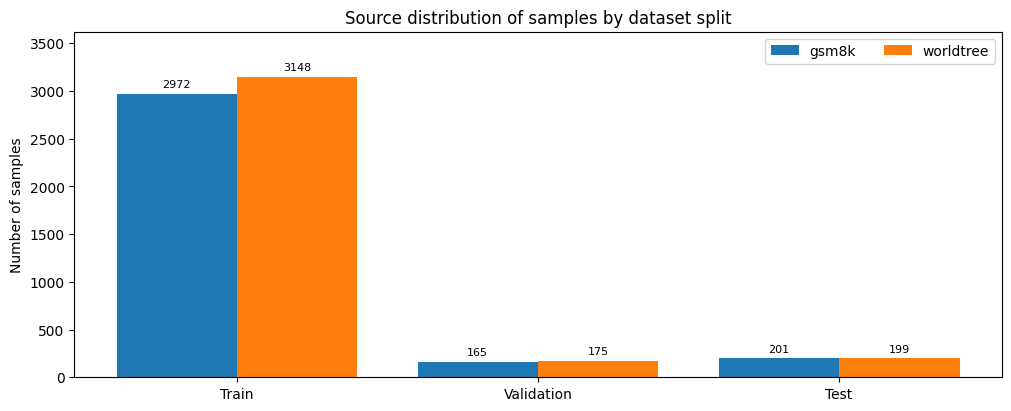

In [13]:
plot_train_val_test_souce_distribution(train_dataset_sft, val_dataset_sft, test_dataset_sft)

In [14]:
batch_index = 0

for i, (prompt, answer, source) in enumerate(zip(
    dataset_sft[batch_index]["prompts"], 
    dataset_sft[batch_index]["targets"], 
    dataset_sft[batch_index]["source"],
)):
    print(f"============= SAMPLE {i} {source} =============")
    print(f"Prompt:\n{prompt}\n")
    print(f"Target:\n{answer}")
    print("====================================\n")

============= SAMPLE 0 worldtree =============
Prompt:
<start_of_turn>user
You are given a problem. Think about the problem and provide your reasoning. Place it between <reasoning> and </reasoning>. Then, provide the final answer (i.e., just one numerical value) between <answer> and </answer>.

The drag of wind results in which feature of ocean surface currents?

Choices:
A. movement of water away from the equator
B. cyclical variations in the height of high tides
C. reduction in velocity with distance from Earth's poles
D. deflection of water toward the direction of airflow
<end_of_turn>
<start_of_turn>model

Target:
<reasoning>The drag of wind causes the surface of the water to change its direction toward the direction of the wind.
Deflection is when an object changes its moving direction.
An ocean is a kind of body of water.
Wind is a kind of airflow.
Deflection is a kind of feature of ocean currents.
Ocean currents are found in oceans.
To cause means to result in.</reasoning><answe

...and continue with the GRPO dataset.

In [15]:
# Load train and validation dataset
dataset_grpo = get_dataset_rl(TRAIN_DATA_DIR, "train").batch(TRAIN_MICRO_BATCH_SIZE)[:NUM_BATCHES_GRPO]

if TRAIN_FRACTION_GRPO == 1.0:
  train_dataset_grpo = dataset_grpo.repeat(NUM_EPOCHS_GRPO)
  val_dataset_grpo = None
else:
  train_dataset_grpo = dataset_grpo[: int(len(dataset_grpo) * TRAIN_FRACTION_GRPO)]
  train_dataset_grpo = train_dataset_grpo.repeat(NUM_EPOCHS_GRPO)
  val_dataset_grpo = dataset_grpo[int(len(dataset_grpo) * TRAIN_FRACTION_GRPO) :].repeat(NUM_EPOCHS_GRPO)

# Load test dataset
test_dataset_grpo = get_dataset_rl(TEST_DATA_DIR, "test").batch(TRAIN_MICRO_BATCH_SIZE)[:NUM_TEST_BATCHES_GRPO]

dataset_lengths_grpo = (
    len(train_dataset_grpo),
    len(val_dataset_grpo) if val_dataset_grpo is not None else 0,
    len(test_dataset_grpo),
)

print(f"GRPO dataset contains {dataset_lengths_grpo} of batches")

GRPO dataset contains (1520, 80, 100) of batches


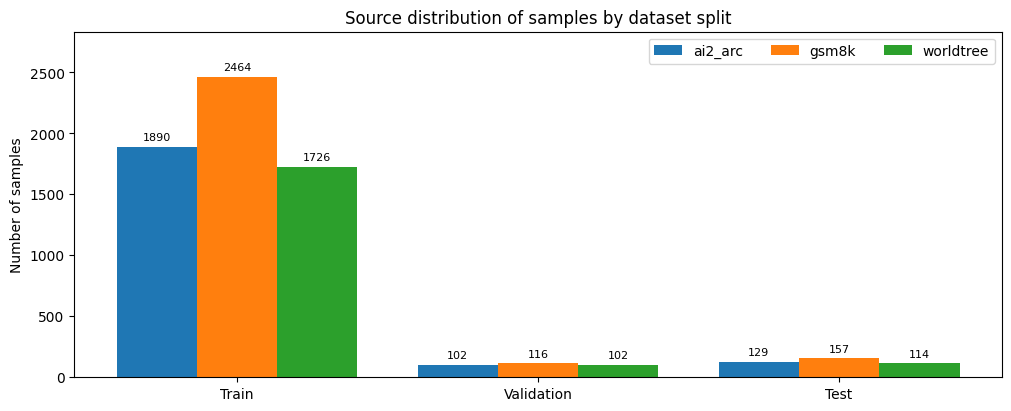

In [16]:
plot_train_val_test_souce_distribution(train_dataset_grpo, val_dataset_grpo, test_dataset_grpo)

In [17]:
batch_index = 0

for i, (prompt, answer, source) in enumerate(zip(
    dataset_grpo[batch_index]["prompts"], 
    dataset_grpo[batch_index]["answer"], 
    dataset_grpo[batch_index]["source"],
)):
    print(f"============= SAMPLE {i} {source} =============")
    print(f"Prompt:\n{prompt}\n")
    print(f"Answer: {answer}")
    print("====================================\n")

============= SAMPLE 0 worldtree =============
Prompt:
<start_of_turn>user
You are given a problem. Think about the problem and provide your reasoning. Place it between <reasoning> and </reasoning>. Then, provide the final answer (i.e., just one numerical value) between <answer> and </answer>.

Students shake salt into a jar of water, and they shake pepper into a second jar of water. Which statement best compares the two jars?

Choices:
A. Only the salt and water is a mixture.
B. Only the pepper and water is a solution.
C. Both jars contain solutions.
D. Both jars contain mixtures.
<end_of_turn>
<start_of_turn>model

Answer: D

============= SAMPLE 1 ai2_arc =============
Prompt:
<start_of_turn>user
You are given a problem. Think about the problem and provide your reasoning. Place it between <reasoning> and </reasoning>. Then, provide the final answer (i.e., just one numerical value) between <answer> and </answer>.

Plants use nutrients found in soil. Which of these can break down in s

## Evaluation

Before starting the first stage of training, we want to measure the baseline performance of the untrained Gemma 3 1B model. For this, we define an evaluation routine that:
- generates responses for a batch of prompts
- checks whether the output follows the required tag format
- checks answer correctness
- reports metrics (answer correctness, format accuracy, reasoning and answer length) both overall and per dataset source

Using that function, we can track the training progress and results of our model.

In [18]:
def generate(question, sampler, temperature=0.7, top_k=50, top_p=0.95, seed=None):
  if isinstance(question, str):
    input_batch = [
        TEMPLATE.format(
            system_prompt=SYSTEM_PROMPT,
            question=question,
        ),
    ]
  else:
    input_batch = [
        TEMPLATE.format(
            system_prompt=SYSTEM_PROMPT,
            question=q,
        )
        for q in question
    ]

  out_data = sampler(
      input_strings=input_batch,
      max_generation_steps=768,
      temperature=temperature,
      top_k=top_k,
      top_p=top_p,
      echo=False,
      seed=seed if seed is not None else None,
      eos_tokens=[1,106],
  )

  output = out_data.text
  if isinstance(question, str):
    return output[0]
  return output

In [19]:
match_format = re.compile(
    rf"^\s*"
    rf"{reasoning_start}(?P<reasoning>.+?){reasoning_end}.*?"
    rf"{solution_start}(?P<answer>.+?){solution_end}"
    rf"\s*$",
    flags=re.MULTILINE | re.DOTALL,
)

match_numbers = re.compile(
    rf"{solution_start}.*?([\d\.]{{1,}})", flags=re.MULTILINE | re.DOTALL
)


def extract_reasoning_and_answer(response: str):
    match = match_format.search(response)
    if not match:
        return None, None
    reasoning_text = (match.group("reasoning") or "").strip()
    answer_text = (match.group("answer") or "").strip()
    return reasoning_text, answer_text


def extract_answer(response):
    match = match_format.search(response)
    return match.group("answer") if match else None


def parse_multiple_choice_letter(text):
    if text is None:
        return None
    s = str(text).upper()

    match = re.search(r"(?:\bANSWER\b\s*[:\-]?\s*|\()([A-E])\b", s)
    if match:
        return match.group(1)

    letters = re.findall(r"[A-E]", s)
    return letters[-1] if letters else None


def is_gsm8k_correct(response, true_answer):
    guess = extract_answer(response)
    if guess is None:
        match = match_numbers.search(response)
        guess = match.group(1) if (match and match.lastindex) else (match.group(0) if match else None)

    if guess is None:
        return False

    try:
        return float(str(guess).strip()) == float(str(true_answer).strip())
    except Exception:
        return False


def is_multiple_choice_correct(response, true_answer):
    extracted = extract_answer(response)
    letter = parse_multiple_choice_letter(extracted if extracted is not None else response)
    if letter is None:
        return False
    return letter == str(true_answer).strip().upper()


def is_format_ok(response: str) -> bool:
    return match_format.search(response) is not None


def evaluate(
    dataset,
    sampler,
    temperature=0.7,
    top_k=50,
    top_p=0.95,
    num_passes=1,
):
    total_examples = 0
    correct_total = 0
    format_total = 0

    examples_by_source = defaultdict(int)
    correct_by_source = defaultdict(int)
    format_by_source = defaultdict(int)

    parsed_count_total = 0
    reasoning_chars_sum = 0
    answer_chars_sum = 0
    reasoning_tokens_sum = 0
    answer_tokens_sum = 0

    parsed_count_by_source = defaultdict(int)
    reasoning_chars_sum_by_source = defaultdict(int)
    answer_chars_sum_by_source = defaultdict(int)
    reasoning_tokens_sum_by_source = defaultdict(int)
    answer_tokens_sum_by_source = defaultdict(int)

    tokenizer = getattr(sampler, "tokenizer", None)

    def count_tokens(text: str) -> int:
        if tokenizer is None:
            return 0
        try:
            return len(tokenizer.encode(text))
        except Exception:
            return 0

    for batch in tqdm(dataset):
        questions = batch["question"]
        answers = batch["answer"]
        sources = batch["source"]

        all_responses_per_example = [[] for _ in range(len(questions))]
        for pass_index in range(num_passes):
            responses = generate(
                questions,
                sampler,
                temperature,
                top_k,
                top_p,
                seed=pass_index,
            )
            for i, response_text in enumerate(responses):
                all_responses_per_example[i].append(response_text)

        for responses_list, true_answer, source_name in zip(all_responses_per_example, answers, sources):
            source_name = str(source_name)
            if source_name not in ("gsm8k", "ai2_arc", "worldtree"):
                raise ValueError(f"Unknown source '{source_name}'")

            got_correct = False
            got_format = False

            selected_response = responses_list[0] if responses_list else ""

            for response_text in responses_list:
                response_has_format = is_format_ok(response_text)
                response_is_correct = (
                    is_gsm8k_correct(response_text, true_answer)
                    if source_name == "gsm8k"
                    else is_multiple_choice_correct(response_text, true_answer)
                )
                if response_has_format and response_is_correct:
                    selected_response = response_text
                    break

            if not is_format_ok(selected_response):
                for response_text in responses_list:
                    if is_format_ok(response_text):
                        selected_response = response_text
                        break

            for response_text in responses_list:
                if not got_format and is_format_ok(response_text):
                    got_format = True

                if source_name == "gsm8k":
                    if is_gsm8k_correct(response_text, true_answer):
                        got_correct = True
                else:
                    if is_multiple_choice_correct(response_text, true_answer):
                        got_correct = True

                if got_correct and got_format:
                    break

            total_examples += 1
            examples_by_source[source_name] += 1

            if got_correct:
                correct_total += 1
                correct_by_source[source_name] += 1
            if got_format:
                format_total += 1
                format_by_source[source_name] += 1

            reasoning_text, answer_text = extract_reasoning_and_answer(selected_response)
            if reasoning_text is not None and answer_text is not None:
                parsed_count_total += 1
                parsed_count_by_source[source_name] += 1

                reasoning_chars = len(reasoning_text)
                answer_chars = len(answer_text)
                reasoning_tokens = count_tokens(reasoning_text)
                answer_tokens = count_tokens(answer_text)

                reasoning_chars_sum += reasoning_chars
                answer_chars_sum += answer_chars
                reasoning_tokens_sum += reasoning_tokens
                answer_tokens_sum += answer_tokens

                reasoning_chars_sum_by_source[source_name] += reasoning_chars
                answer_chars_sum_by_source[source_name] += answer_chars
                reasoning_tokens_sum_by_source[source_name] += reasoning_tokens
                answer_tokens_sum_by_source[source_name] += answer_tokens

    def safe_avg(total_value: int, count: int) -> float:
        return (total_value / count) if count else 0.0

    result = {
        "overall": {
            "total": total_examples,
            "acc_percent": (correct_total / total_examples * 100) if total_examples else 0.0,
            "format_percent": (format_total / total_examples * 100) if total_examples else 0.0,
            "parsed_for_length": parsed_count_total,
            "avg_reasoning_chars": safe_avg(reasoning_chars_sum, parsed_count_total),
            "avg_answer_chars": safe_avg(answer_chars_sum, parsed_count_total),
            "avg_reasoning_tokens": safe_avg(reasoning_tokens_sum, parsed_count_total),
            "avg_answer_tokens": safe_avg(answer_tokens_sum, parsed_count_total),
        },
        "by_source": {}
    }

    for source_name in examples_by_source:
        count = examples_by_source[source_name]
        parsed_count = parsed_count_by_source[source_name]
        result["by_source"][source_name] = {
            "total": count,
            "acc_percent": (correct_by_source[source_name] / count * 100) if count else 0.0,
            "format_percent": (format_by_source[source_name] / count * 100) if count else 0.0,

            "parsed_for_length": parsed_count,
            "avg_reasoning_chars": safe_avg(reasoning_chars_sum_by_source[source_name], parsed_count),
            "avg_answer_chars": safe_avg(answer_chars_sum_by_source[source_name], parsed_count),
            "avg_reasoning_tokens": safe_avg(reasoning_tokens_sum_by_source[source_name], parsed_count),
            "avg_answer_tokens": safe_avg(answer_tokens_sum_by_source[source_name], parsed_count),
        }

    return result

Using the defined evaluation function above, we can check how the model performs on our given task without any fine-tuning.

In [20]:
sampler = sampler_lib.Sampler(
    transformer=lora_model,
    tokenizer=tokenizer,
    cache_config=sampler_lib.CacheConfig(
        cache_size=MAX_PROMPT_LENGTH + TOTAL_GENERATION_STEPS + 256,
        num_layers=model_config.num_layers,
        num_kv_heads=model_config.num_kv_heads,
        head_dim=model_config.head_dim,
    ),
)

before_training_results = evaluate(
    test_dataset_grpo,
    sampler,
    **GENERATION_CONFIGS["greedy"],
)

before_training_results

  0%|          | 0/100 [00:00<?, ?it/s]

{'overall': {'total': 400,
  'acc_percent': 5.5,
  'format_percent': 20.5,
  'parsed_for_length': 82,
  'avg_reasoning_chars': 569.5121951219512,
  'avg_answer_chars': 2.6341463414634148,
  'avg_reasoning_tokens': 155.91463414634146,
  'avg_answer_tokens': 2.4878048780487805},
 'by_source': {'ai2_arc': {'total': 129,
   'acc_percent': 0.7751937984496124,
   'format_percent': 7.751937984496124,
   'parsed_for_length': 10,
   'avg_reasoning_chars': 642.2,
   'avg_answer_chars': 2.1,
   'avg_reasoning_tokens': 134.2,
   'avg_answer_tokens': 1.6},
  'gsm8k': {'total': 157,
   'acc_percent': 12.738853503184714,
   'format_percent': 41.40127388535032,
   'parsed_for_length': 65,
   'avg_reasoning_chars': 565.6461538461539,
   'avg_answer_chars': 2.8,
   'avg_reasoning_tokens': 164.8,
   'avg_answer_tokens': 2.707692307692308},
  'worldtree': {'total': 114,
   'acc_percent': 0.8771929824561403,
   'format_percent': 6.140350877192982,
   'parsed_for_length': 7,
   'avg_reasoning_chars': 501.57

It can be noticed that the baseline performance is fairly bad. The overall accuracy is just 5% and also the formatting has plenty of room for improvement with 20%. Let's see how much we can improve our metrics by SFT and GRPO. :)

## Supervised fine-tuning

After preprocessing and the baseline evaluation, we can finally start the first stage of our training pipeline: SFT. For SFT, the dataset needs to be converted into model-ready tensors. The following helper functions therefore tokenize the prompt and target, build a training mask, and create the attention masks required by the transformer.

In [21]:
def encode_text(text: str) -> list[int]:
    return tokenizer.encode(text)


PAD_ID = tokenizer.pad_id() if hasattr(tokenizer, "pad_id") else 0


def make_sft_example(prompt_text: str, target_text: str, max_length: int) -> dict:
    prompt_ids = tokenizer.encode(prompt_text)
    target_ids = tokenizer.encode(target_text)

    combined_ids = (prompt_ids + target_ids)[:max_length]

    prompt_len = min(len(prompt_ids), max_length)
    target_len = max(0, min(len(target_ids), max_length - prompt_len))

    input_mask = ([0] * prompt_len) + ([1] * target_len)
    input_mask = input_mask[:len(combined_ids)]

    if len(combined_ids) < max_length:
        pad_len = max_length - len(combined_ids)
        combined_ids = combined_ids + [PAD_ID] * pad_len
        input_mask = input_mask + [0] * pad_len

    return {
        "input_tokens": np.asarray(combined_ids, dtype=np.int32),
        "input_mask": np.asarray(input_mask, dtype=np.int32),
    }


def gen_model_input_fn(example):
    pad_mask = example["input_tokens"] != PAD_ID
    positions = sft_utils.build_positions_from_mask(pad_mask)
    attention_mask = sft_utils.make_causal_attn_mask(pad_mask)
    return {
        "input_tokens": example["input_tokens"],
        "input_mask": example["input_mask"] ,
        "positions": positions,
        "attention_mask": attention_mask,
    }


SFT_MAX_LENGTH = 1024


def sft_iterator(grain_dataset):
    for row in grain_dataset:
        prompts = row["prompts"]
        targets = row["targets"]

        prompts = [as_text(x) for x in prompts]
        targets = [as_text(x) for x in targets]

        batch = [make_sft_example(p, t, max_length=SFT_MAX_LENGTH) for p, t in zip(prompts, targets)]

        input_tokens = np.stack([b["input_tokens"] for b in batch], axis=0)
        input_mask   = np.stack([b["input_mask"]   for b in batch], axis=0)

        yield {"input_tokens": input_tokens, "input_mask": input_mask}


Using the utility functions above and our predefined hyperparameters, we now configure and run SFT with `PeftTrainer`. We set up metric logging and checkpointing, use AdamW with gradient clipping for stability, and start training on the LoRA model.

A small but important detail is the `FreshIterable` wrapper for the validation iterator: it ensures that the validation data can be iterated repeatedly across evaluation steps. Without it, the training would crash when the validation set is exhausted after the first pass.

In [22]:
os.makedirs(SFT_CKPT_DIR, exist_ok=True)

sft_logger_options = metrics_logger.MetricsLoggerOptions(
    log_dir=SFT_METRICS_DIR,
    flush_every_n_steps=20,
)

sft_training_config = peft_trainer.TrainingConfig(
    eval_every_n_steps=EVAL_EVERY_N_STEPS_SFT,
    max_steps=MAX_STEPS_SFT,
    metrics_logging_options=sft_logger_options,
    checkpoint_root_directory=SFT_CKPT_DIR,
)

sft_optimizer = optax.adamw(LEARNING_RATE_SFT, weight_decay=WEIGHT_DECAY_SFT)
sft_optimizer = optax.chain(
    optax.clip_by_global_norm(max_norm=MAX_GRAD_NORM_SFT),
    sft_optimizer,
)

sft_trainer = peft_trainer.PeftTrainer(
    lora_model,
    sft_optimizer,
    sft_training_config,
).with_gen_model_input_fn(gen_model_input_fn)

class FreshIterable:
    def __init__(self, make_iterator_fn):
        self._make_iterator_fn = make_iterator_fn

    def __iter__(self):
        return self._make_iterator_fn()

sft_train_iter = sft_iterator(train_dataset_sft)
sft_val_iter = None if val_dataset_sft is None else FreshIterable(lambda: sft_iterator(val_dataset_sft))


with mesh:
    sft_trainer.train(sft_train_iter, sft_val_iter)
sft_trainer.close()

Training:   0%|          | 0/1530 [00:00<?, ?step/s]

The trainer saved some metrics during training, that we can now have a quick look at:

In [24]:
event_file = sorted(Path(SFT_METRICS_DIR).glob("events.out.tfevents.*"))[-1]

ea = EventAccumulator(str(event_file))
ea.Reload()

tags = ea.Tags().get("scalars", [])

rows = []
for tag in tags:
    for e in ea.Scalars(tag):
        rows.append((e.step, tag, e.value))

sft_metrics_df = pd.DataFrame(rows, columns=["step", "tag", "value"])
sft_metrics_df["tag"].unique()

array(['jax/core/compile/jaxpr_trace_duration',
       'jax/core/compile/jaxpr_to_mlir_module_duration',
       'jax/core/compile/backend_compile_duration', 'eval/loss',
       'eval/perplexity', 'eval/step_time_sec', 'eval/steps_per_sec',
       'train/tflops_per_step', 'jax/orbax/write/sharded_array_gb',
       'jax/orbax/write/replicated_array_gb', 'train/loss',
       'train/perplexity', 'train/step_time_sec', 'train/steps_per_sec'],
      dtype=object)

In [44]:
def plot_train_eval_metrics(metrics_df, tag):
    train_df = metrics_df[metrics_df["tag"] == f"train/{tag}"].sort_values("step")
    
    eval_df = metrics_df[metrics_df["tag"] == f"eval/{tag}"].sort_values("step")
    
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))
    
    axes[0].plot(train_df["step"], train_df["value"])
    axes[0].set_title(f"Train {tag}")
    axes[0].set_xlabel("Step")
    axes[0].set_ylabel(f"{tag}")
    
    axes[1].plot(eval_df["step"], eval_df["value"])
    axes[1].set_title(f"Val {tag}")
    axes[1].set_xlabel("step")
    
    plt.tight_layout()
    plt.show()

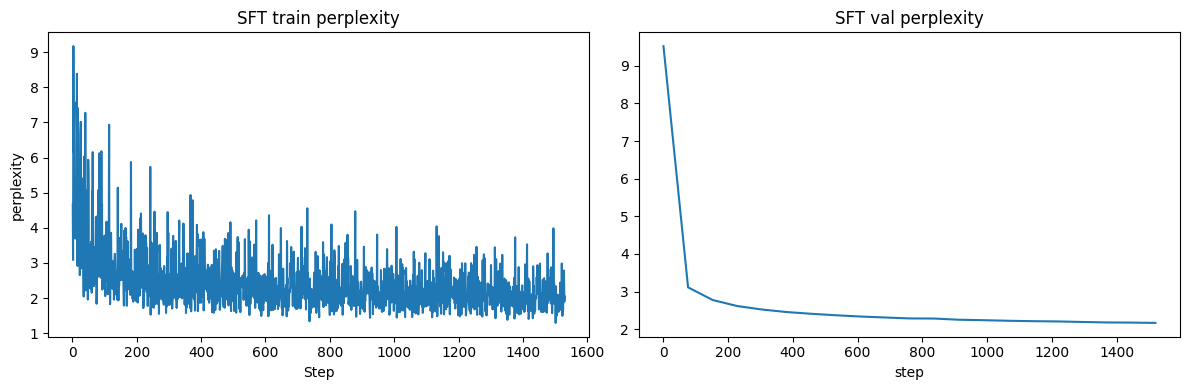

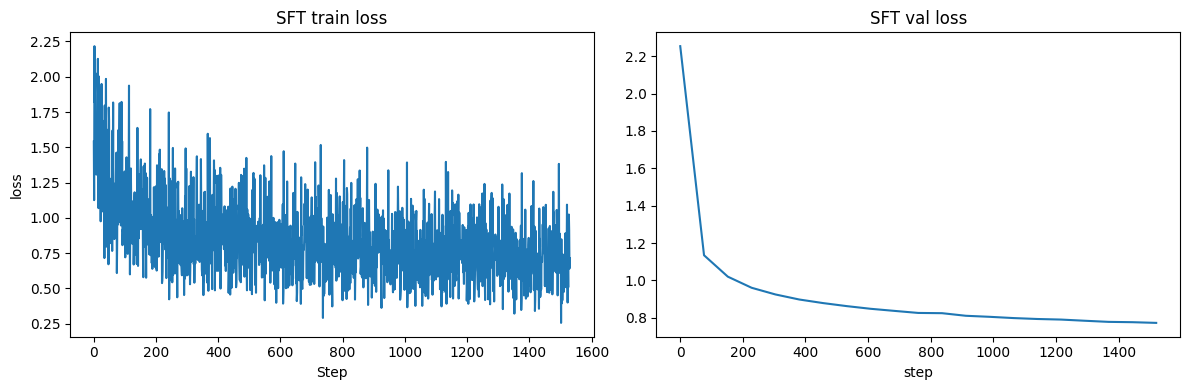

In [26]:
plot_train_eval_metrics(sft_metrics_df, "perplexity")
plot_train_eval_metrics(sft_metrics_df, "loss")

Inspecting these results, both the SFT perplexity and loss look healthy: 
- Validation perplexity decreases smoothly and stabilizes around 2. That indicates SFT is improving next-token prediction on the target format without obvious instability.
- validation loss decreases smoothly and then plateaus around 0.8. This suggests the model is learning the target format/behavior and training is stable, with no obvious signs of overfitting in this run.

Let's also test the performance of the SFT tuned model on our evaluation set like we did with the baseline model. To do so, we first load the last saved checkpoint:

In [27]:
def find_latest_step_dir(checkpoint_root: str) -> str:
    candidates = []
    for name in os.listdir(checkpoint_root):
        path = os.path.join(checkpoint_root, name)
        if os.path.isdir(path) and re.fullmatch(r"\d+", name):
            candidates.append(int(name))
    if not candidates:
        raise FileNotFoundError(f"No numeric step directories found in {checkpoint_root}")
    latest = str(max(candidates))
    return os.path.join(checkpoint_root, latest)

latest_sft_step_dir = find_latest_step_dir(SFT_CKPT_DIR)
print("Latest SFT checkpoint dir:", latest_sft_step_dir)

Latest SFT checkpoint dir: /kaggle/working/sft_ckpts/1530


In [28]:
wandb.init(mode="disabled")

def restore_lora_params_into_model(lora_model, ckpt_path: str):
    abstract_lora = jax.tree.map(
        lambda x: jax.ShapeDtypeStruct(x.shape, x.dtype),
        nnx.state(lora_model, nnx.LoRAParam),
    )
    checkpointer = ocp.StandardCheckpointer()
    restored = checkpointer.restore(ckpt_path, target=abstract_lora)

    nnx.update(
        lora_model,
        jax.tree.map(
            lambda old, new: new,
            nnx.state(lora_model, nnx.LoRAParam),
            restored,
        ),
    )

maybe_model_params = os.path.join(latest_sft_step_dir, "model_params")
ckpt_to_restore = maybe_model_params if os.path.exists(maybe_model_params) else latest_sft_step_dir

restore_lora_params_into_model(lora_model, ckpt_to_restore)
print("LoRA params restored from:", ckpt_to_restore)

graph_def, state = nnx.split(lora_model)

state_copy = jax.tree.map(
    lambda x: x.copy() if hasattr(x, "copy") else x,
    state,
)

ref_model = nnx.merge(graph_def, state_copy)

with mesh:
    ref_state = nnx.state(ref_model)
    ref_pspecs = nnx.get_partition_spec(ref_state)
    ref_state = jax.lax.with_sharding_constraint(ref_state, ref_pspecs)
    nnx.update(ref_model, ref_state)

/usr/local/lib/python3.12/site-packages/orbax/checkpoint/_src/serialization/type_handlers.py:1269: UserWarning: Sharding info not provided when restoring. Populating sharding info from sharding file. Please note restoration time will be slightly increased due to reading from file. Note also that this option is unsafe when restoring on a different topology than the checkpoint was saved with.
  warnings.warn(


LoRA params restored from: /kaggle/working/sft_ckpts/1530/model_params


After loading the fine-tuned model, we now run the same evaluation function as we did before:

In [29]:
sampler = sampler_lib.Sampler(
    transformer=ref_model,
    tokenizer=tokenizer,
    cache_config=sampler_lib.CacheConfig(
        cache_size=MAX_PROMPT_LENGTH + TOTAL_GENERATION_STEPS + 256,
        num_layers=model_config.num_layers,
        num_kv_heads=model_config.num_kv_heads,
        head_dim=model_config.head_dim,
    ),
)

after_sft_results = evaluate(
    test_dataset_grpo,
    sampler,
    **GENERATION_CONFIGS["greedy"],
)

after_sft_results

  0%|          | 0/100 [00:00<?, ?it/s]

{'overall': {'total': 400,
  'acc_percent': 42.25,
  'format_percent': 82.5,
  'parsed_for_length': 330,
  'avg_reasoning_chars': 367.07878787878786,
  'avg_answer_chars': 1.4575757575757575,
  'avg_reasoning_tokens': 86.87878787878788,
  'avg_answer_tokens': 1.4575757575757575},
 'by_source': {'ai2_arc': {'total': 129,
   'acc_percent': 39.53488372093023,
   'format_percent': 94.57364341085271,
   'parsed_for_length': 122,
   'avg_reasoning_chars': 395.9590163934426,
   'avg_answer_chars': 1.0,
   'avg_reasoning_tokens': 78.5327868852459,
   'avg_answer_tokens': 1.0},
  'gsm8k': {'total': 157,
   'acc_percent': 26.751592356687897,
   'format_percent': 63.05732484076433,
   'parsed_for_length': 99,
   'avg_reasoning_chars': 324.73737373737373,
   'avg_answer_chars': 2.525252525252525,
   'avg_reasoning_tokens': 109.6969696969697,
   'avg_answer_tokens': 2.525252525252525},
  'worldtree': {'total': 114,
   'acc_percent': 66.66666666666666,
   'format_percent': 95.6140350877193,
   'pars

SFT gives a big jump in both objectives:
- The overall answer correctness rises from 5.5% to 42.25%, and format accuracy from 20.5% to 82.5%. The model now mostly produces valid \<reasoning> and \<answer> outputs!
- By source, the biggest improvements are on the multiple-choice datasets: worldtree reaches 66.7% (before 0.9%) answer correctness with 95.5% (before 6.1%) format accuracy, and ai2_arc reaches 39.5% (before 0.8%) answer accuracy with 94.6% (before 7.8%) format accuracy (even though it wasn't part of the training set!).
- The improvement of gsm8k is smaller and especially the increase of answer correcntess from 12.7% to 26.8% is a lot smaller than for the other two datasets. This suggests that numeric answering is more error-prone than selecting a multiple-choice letter.
- The average reasoning becomes noticeably shorter (156 to 87 token overall). This is consistent with the SFT supervision: the training datasets used here contain relatively compact reasoning traces, and the model adapts to that style.

## Reward functions for GRPO

In this section, we prepare rewards function to use them later for GRPO. We use two main components: a format reward that encourages the required \<reasoning> and \<answer> structure, and an answer reward that rewards correctness. The exact values were chosen empirically to balance formatting and accuracy.

In [30]:
# Rewards for formatting
FORMAT_MATCHES_EXACTLY_REWARD = 3
FORMAT_TAG_COUNT_CORRECT_REWARD = 0.5
FORMAT_TAG_COUNT_NOT_FOUND_PENALTY = -0.25
FORMAT_TAG_COUNT_TOO_MANY_PENALTY = -0.5

# Rewards for answer
CORRECT_ANSWER_REWARD = 5
CLOSE_TO_CORRECT_ANSWER_REWARD = 0.25
VERY_CLOSE_TO_CORRECT_ANSWER_REWARD = 0.5
NO_ANSWER_PENALTY = -0.5
WRONG_ANSWER_PENALTY = -1

NO_REWARD = 0

Here we implement the first GRPO reward function: It assigns a positive reward if the model output matches required format exactly. If the format doesn't match, no reward is given.

In [31]:
def match_format_exactly(prompts, completions, **kwargs):

    return [
        NO_REWARD if match_format.search(response) is None else FORMAT_MATCHES_EXACTLY_REWARD
        for response in completions
    ]

match_format_exactly(
    ["Prompt 1", "Prompt 2"], 
    [
        f"{reasoning_start}Reasoning{reasoning_end}{solution_start}Answer{solution_end}",
        f"{reasoning_start}Wrong reasoning{solution_start}Answer{solution_end}"
    ],
)

[3, 0]

In the next cell, we implement a softer format shaping function than the one above. Instead of requiring a perfect match, it scores each of the four tags separately:
- Reward if a tag appears exactly once
- Penalize if a tag is missing
- Penalize when a single tag appears multiple times

In [32]:
def get_partial_format_score(tag, response):
    tag_count = response.count(tag)
    
    # Reward correct occurence of tag
    if tag_count == 1: 
        return FORMAT_TAG_COUNT_CORRECT_REWARD
        
    # Penalize tag spamming
    elif tag_count > 1:
        return FORMAT_TAG_COUNT_TOO_MANY_PENALTY

    # Penalize missing tag
    return FORMAT_TAG_COUNT_NOT_FOUND_PENALTY


def match_format_approximately(prompts, completions, **kwargs):
    scores = []
    
    for completion in completions:
        score = 0
        response = completion

        score += get_partial_format_score(reasoning_start, completion)
        score += get_partial_format_score(reasoning_end, completion)
        score += get_partial_format_score(solution_start, completion)
        score += get_partial_format_score(solution_end, completion)

        scores.append(score)
    return scores


match_format_approximately(
    ["Prompt 1", "Prompt 2", "Prompt 3", "Prompt 4", "Prompt 5"], 
    [
        f"{reasoning_start}Reasoning{reasoning_end}{solution_start}Answer{solution_end}",
        f"{reasoning_start}Wrong reasoning{solution_start}Answer{solution_end}",
        f"{reasoning_start}",
        f"",
        f"{reasoning_start}Wrong reasoning{solution_start}Answer{solution_end}{solution_end}{solution_end}",
    ],
)

[2.0, 1.25, -0.25, -1.0, 0.25]

Next we implement a reward function that checks the accuracy of the answer and incentivizes correct answers by rewarding them. Since our three datasets have different answer types, the reward is source-dependent:
- Gsm8k: We compare numeric answers and additionally provide small shaping rewards when the prediction is close to the ground truth value.
- Worldtree and ai2_arc: We extract the multiple-choice letter (A–E) and reward only an exact match. We do not reward approximate matches here, since partial credit would be easy to obtain by guessing.

If the answer is wrong, a penalty is given.

The `check_answer` function combines the answer checking for all datasets by extracting the model’s \<answer>...\</answer> content and returning the corresponding reward per sample taking its source into account.

In [33]:
def get_multiple_choice_answer_score(guess, true_answer):
    guess = str(guess).strip().upper()
    true_answer = str(true_answer).strip().upper()

    guess = re.sub(r"[^A-E]", "", guess)

    if guess == "":
        return NO_ANSWER_PENALTY

    return CORRECT_ANSWER_REWARD if guess == true_answer else WRONG_ANSWER_PENALTY


def get_gsm8k_answer_score(guess, true_answer):
    guess = str(guess)
    true_answer = str(true_answer)

    if guess.strip() == true_answer.strip():
        return CORRECT_ANSWER_REWARD

    try:
        ratio = float(guess) / float(true_answer)
        if 0.9 <= ratio <= 1.1:
            return VERY_CLOSE_TO_CORRECT_ANSWER_REWARD
        if 0.8 <= ratio <= 1.2:
            return CLOSE_TO_CORRECT_ANSWER_REWARD
        return WRONG_ANSWER_PENALTY
    except Exception:
        return NO_ANSWER_PENALTY
        

def check_answer(prompts, completions, answer, source, **kwargs):   
    responses = completions

    if source is None:
        source = kwargs.get("source", None)

    if source is None:
        raise ValueError(
            "check_answer requires `source` (list[str]) to be passed. "
            "Make sure your dataset has a 'source' column and Tunix forwards it."
        )

    if len(source) != len(answer) or len(responses) != len(answer):
        raise ValueError(
            f"Length mismatch: len(responses)={len(responses)}, "
            f"len(answers)={len(answer)}, len(source)={len(source)}"
        )

    guesses = [
        m.group("answer") if (m := match_format.search(response)) is not None else None
        for response in responses
    ]

    # print("Check answer =====================================")
    # print(f"Prompt: {prompts[0]}\n")
    # print(f"Response: {responses[0]}\n")
    # print(f"Extracted guess: {guesses[0]}")
    # print(f"True answer: {answer[0]}")
    # print("==================================================")

    scores = []
    for guess, true_answer, src in zip(guesses, answer, source):
        if guess is None:
            scores.append(NO_REWARD)
            continue

        if src == "gsm8k":
            scores.append(get_gsm8k_answer_score(guess, true_answer))
        elif src == "ai2_arc" or src == "worldtree":
            scores.append(get_multiple_choice_answer_score(guess, true_answer))
        else:
            raise ValueError(f"Unknown source='{src}'. Expected 'gsm8k' or 'ai2_arc'.")

    return scores


print(
    check_answer(
        ["Prompt 1", "Prompt 2", "Prompt 3", "Prompt 4"],
        [f"{reasoning_start}R{reasoning_end}{solution_start}100{solution_end}",
         f"{reasoning_start}R{reasoning_end}{solution_start}10{solution_end}",
         f"{reasoning_start}R{reasoning_end}{solution_start}E{solution_end}",
         f"{reasoning_start}R{reasoning_end}{solution_start}A{solution_end}",
         f"{reasoning_start}R{reasoning_end}{solution_start}The answer is: (C).{solution_end}"],
        ["10", "10", "E", "A", "C"],
        ["gsm8k", "gsm8k","worldtree", "ai2_arc", "ai2_arc"],
    )
)

[-1, 5, 5, 5, -1]


## GRPO

After defining the reward functions, we set up the GRPO training configuration using the hyperparameters defined at the beginning of the notebook. This includes checkpointing and metric logging, the optimizer setup, and the training configuration.

Afterwards, we create a GRPOLearner that receives the three reward functions defined above (exact format, approximate format shaping and answer correctness). With this setup, we can start training on the mixed GRPO dataset.

In [34]:
checkpointing_options = ocp.CheckpointManagerOptions(
    save_interval_steps=SAVE_INTERVAL_STEPS, max_to_keep=MAX_TO_KEEP
)

metrics_logging_options = metrics_logger.MetricsLoggerOptions(
    log_dir=METRICS_DIR, flush_every_n_steps=20
)

In [35]:
optimizer = optax.adamw(
    learning_rate=optax.schedules.warmup_cosine_decay_schedule(
        init_value=0.0,
        peak_value=LEARNING_RATE_GRPO,
        warmup_steps=WARMUP_STEPS_GRPO,
        decay_steps=MAX_STEPS_GRPO,
        end_value=0.0,
    ),
    b1=B1,
    b2=B2,
    weight_decay=WEIGHT_DECAY_GRPO,
)

optimizer = optax.chain(
    optax.clip_by_global_norm(max_norm=MAX_GRAD_NORM_GRPO),
    optimizer,
)

In [36]:
# Training config
cluster_config = rl_cluster_lib.ClusterConfig(
    role_to_mesh={
        rl_cluster_lib.Role.ACTOR: mesh,
        rl_cluster_lib.Role.REFERENCE: mesh,
        rl_cluster_lib.Role.ROLLOUT: mesh,
    },
    rollout_engine='vanilla',
    offload_to_cpu=False,
    training_config=rl_cluster_lib.RLTrainingConfig(
        actor_optimizer=optimizer,
        eval_every_n_steps=EVAL_EVERY_N_STEPS_GRPO,
        max_steps=MAX_STEPS_GRPO,
        mini_batch_size=TRAIN_MICRO_BATCH_SIZE,
        train_micro_batch_size=TRAIN_MICRO_BATCH_SIZE,
        metrics_logging_options=metrics_logging_options,
        checkpoint_root_directory=GRPO_CKPT_DIR,
        checkpointing_options=checkpointing_options,
    ),
    rollout_config=base_rollout.RolloutConfig(
        max_tokens_to_generate=TOTAL_GENERATION_STEPS,
        max_prompt_length=MAX_PROMPT_LENGTH,
        kv_cache_size=MAX_PROMPT_LENGTH + TOTAL_GENERATION_STEPS + 256,
        temperature=TEMPERATURE,
        top_p=TOP_P,
        top_k=TOP_K,
        eos_tokens=[1,106],
    ),
)

grpo_config = GRPOConfig(
    num_generations=NUM_GENERATIONS,
    num_iterations=NUM_ITERATIONS_GRPO,
    beta=BETA,
    epsilon=EPSILON,
)

In [37]:
rl_cluster = rl_cluster_lib.RLCluster(
    actor=lora_model,
    reference=ref_model,
    tokenizer=tokenizer,
    cluster_config=cluster_config,
)

grpo_learner = GRPOLearner(
    rl_cluster=rl_cluster,
    reward_fns=[
        match_format_exactly,
        match_format_approximately,
        check_answer,
    ],
    grpo_config=grpo_config,
)

with mesh:
  grpo_learner.train(train_dataset_grpo, val_dataset_grpo)

Actor Training:   0%|          | 0/1520 [00:00<?, ?step/s]

As with SFT, we logged several metrics during GRPO training:

In [38]:
event_file = sorted(Path(SFT_METRICS_DIR).glob("events.out.tfevents.*"))[-1]

ea = EventAccumulator(str(event_file))
ea.Reload()

tags = ea.Tags().get("scalars", [])

rows = []
for tag in tags:
    for e in ea.Scalars(tag):
        rows.append((e.step, tag, e.value))

grpo_metrics_df = pd.DataFrame(rows, columns=["step", "tag", "value"])
grpo_metrics_df["tag"].unique()

array(['jax/orbax/write/sharded_array_gb',
       'jax/orbax/write/replicated_array_gb',
       'jax/core/compile/jaxpr_trace_duration',
       'jax/core/compile/jaxpr_to_mlir_module_duration',
       'jax/core/compile/backend_compile_duration', 'actor/eval/loss',
       'actor/eval/perplexity', 'actor/eval/step_time_sec',
       'actor/eval/steps_per_sec', 'actor/eval/kl',
       'actor/train/tflops_per_step',
       'train/rewards/match_format_exactly',
       'train/rewards/match_format_approximately',
       'train/rewards/check_answer', 'train/rewards/overall',
       'train/rewards/min', 'train/completions/mean_length',
       'train/completions/max_length', 'train/completions/min_length',
       'eval/rewards/match_format_exactly',
       'eval/rewards/match_format_approximately',
       'eval/rewards/check_answer', 'eval/rewards/overall',
       'eval/rewards/min', 'eval/completions/mean_length',
       'eval/completions/max_length', 'eval/completions/min_length',
       'actor

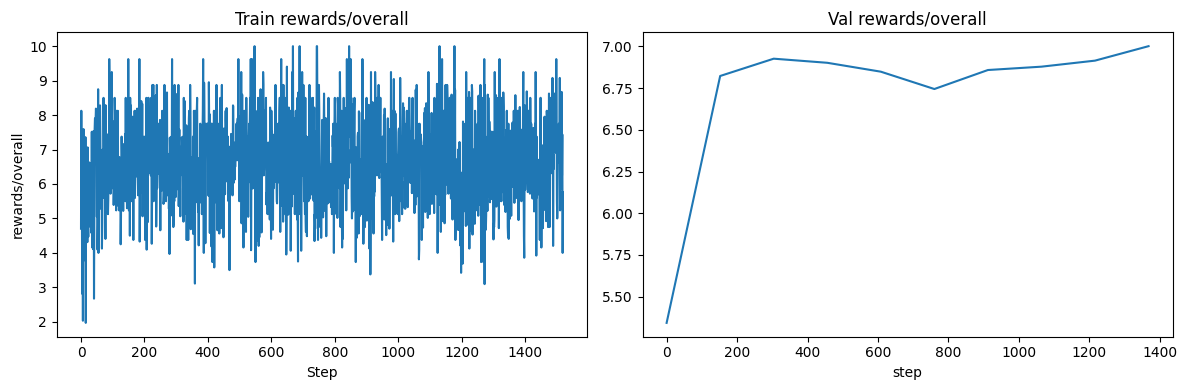

In [45]:
plot_train_eval_metrics(grpo_metrics_df, "rewards/overall")

The plot above shows the overall rewards during training. On the validation set, the reward increases from about 5 to 7, which suggests GRPO is successfully optimizing the reward objective. The training reward is rather noisy, but it stays in a stable range without collapsing, indicating training remains reasonably stable.

## Final evaluation

After completing the last step of the training pipeline with GRPO, we run a final evaluation to inspect, how the models performance on the testset changed. To do that, we load the most recent checkpoint of the trained GRPO model and run the evaluate function one last time.

In [40]:
actor_ckpt_dir = os.path.join(GRPO_CKPT_DIR, "actor")

latest_step = -1
if os.path.exists(actor_ckpt_dir):
  for item in os.listdir(actor_ckpt_dir):
    if os.path.isdir(os.path.join(actor_ckpt_dir, item)) and re.match(r'^\d+$', item):
      step = int(item)
      if step > latest_step:
        latest_step = step

if latest_step == -1:
  raise FileNotFoundError(f"No checkpoints found in {actor_ckpt_dir}")

print(f"Latest checkpoint step: {latest_step}")

wandb.init(mode="disabled")

trained_ckpt_path = os.path.join(
    GRPO_CKPT_DIR, "actor", str(latest_step), "model_params"
)

abs_params = jax.tree.map(
    lambda x: jax.ShapeDtypeStruct(x.shape, x.dtype),
    nnx.state(lora_model, nnx.LoRAParam),
)
checkpointer = ocp.StandardCheckpointer()
trained_lora_params = checkpointer.restore(trained_ckpt_path, target=abs_params)

nnx.update(
    lora_model,
    jax.tree.map(
        lambda a, b: b,
        nnx.state(lora_model, nnx.LoRAParam),
        trained_lora_params,
    ),
)

Latest checkpoint step: 1520


In [41]:
sampler = sampler_lib.Sampler(
    transformer=lora_model,
    tokenizer=tokenizer,
    cache_config=sampler_lib.CacheConfig(
        cache_size=MAX_PROMPT_LENGTH + TOTAL_GENERATION_STEPS + 256,
        num_layers=model_config.num_layers,
        num_kv_heads=model_config.num_kv_heads,
        head_dim=model_config.head_dim,
    ),
)

after_grpo_results = evaluate(
    test_dataset_grpo,
    sampler,
    **GENERATION_CONFIGS["greedy"],
)

  0%|          | 0/100 [00:00<?, ?it/s]

To make the performance changes across the pipeline easier to compare, we aggregate the evaluation results from Baseline, SFT, and GRPO into a single DataFrame. This lets us view key metrics side-by-side, both overall and per dataset source.

In [42]:
def format_results(results_dict):
    combined = {"Overall": results_dict["overall"], **results_dict["by_source"]}
    return pd.DataFrame(combined).T

all_data = {
    "Baseline": before_training_results,
    "SFT": after_sft_results,
    "GRPO": after_grpo_results
}

final_df = pd.concat(
    {stage: format_results(data) for stage, data in all_data.items()}, 
    axis=1
)

metrics_to_show = {
    "acc_percent": "Accuracy (%)",
    "format_percent": "Format (%)",
    "avg_reasoning_tokens": "Average reasoning tokens"
}

for metric, label in metrics_to_show.items():
    print(f"\n===== {label} comparison =====")
    display(final_df.xs(metric, axis=1, level=1))


===== Accuracy (%) comparison =====


,Baseline,SFT,GRPO
Overall,5.500000,42.250000,48.250000
ai2_arc,0.775194,39.534884,43.410853
gsm8k,12.738854,26.751592,36.305732
worldtree,0.877193,66.666667,70.175439



===== Format (%) comparison =====


,Baseline,SFT,GRPO
Overall,20.500000,82.500000,98.000000
ai2_arc,7.751938,94.573643,99.224806
gsm8k,41.401274,63.057325,95.541401
worldtree,6.140351,95.614035,100.000000



===== Average reasoning tokens comparison =====


,Baseline,SFT,GRPO
Overall,155.914634,86.878788,93.272959
ai2_arc,134.200000,78.532787,80.742188
gsm8k,164.800000,109.696970,114.946667
worldtree,104.428571,75.495413,78.824561


It can be seen that GRPO improves the SFT model further. The overall accuracy increases by 6% from 42.25 to 48.25%. Format accuracy also benefits from the training and ascends by 15.5% from 82.5% to 98.0%. The largest format gain is on gsm8k from 63.1% to 95.5%, showing that GRPO strongly reduces remaining formatting failures. Accuracy also improves for all data sources: ai2_arc from 39.5% to 43.4%, gsm8k from 26.8% to 36.3%, and worldtree from 66.7% to 70.2%. 
An interesting observation is that the average reasoning length increases slightly from 87 93 tokens. This suggests that GRPO encourages somewhat more detailed reasoning while still complying with the required structure

Overall, the results show that the pipeline works as intended: SFT provides a major jump in both correctness and formatting with a short, resource-efficient training, while GRPO acts as a refinement step that pushes format adherence close to perfect and adds an additional accuracy boost across all datasets. The models performance is strongest on multiple-choice science QA (ai2_arc and worldtree), whereas numeric math (gsm8k) remains the most challenging, but still benefits noticeably from GRPO.

Finally, we package the trained checkpoints into a single .zip archive so the model can be downloaded and reused outside of this notebook.

In [43]:
shutil.make_archive("/kaggle/working/results/trained_model", "zip", GRPO_CKPT_DIR)

'/kaggle/working/results/trained_model.zip'

## Future work

A interesting direction for future work would be to validate whether the proposed SFT and GRPO pipeline is truly a compute-efficient choice. While the warm start clearly improves early performance, it would be useful to compare against a GRPO-only baseline under a matched compute budget. This would clarify how much of the final gain comes from SFT versus GRPO, and whether worse/similar/better results can be achieved with a single-stage approach.

In addition, it would be important to evaluate generalization beyond the training mix used in this submission. Since the datasets are dominated by math and multiple-choice QA, future work should test the model on broader tasks (e.g., summarization, coding or writing) to check how well it transfers and whether it shows any capability forgetting. If degradation is observed, one could mitigate it by adding a small amount of diverse instruction data during SFT, by incorporating other rewards or using a wider dataset mixture during GRPO.